In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

In [2]:
with open('../data/SNLS80mV.csv','r') as f:
    data1 = np.loadtxt(f,delimiter=',')

with open('../data/ewa.csv','r') as f:
    data2 = np.loadtxt(f,delimiter=',')

# Narmax Model

In [3]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.display_results import results

## Sinal 1

In [5]:
n_cols = data1.shape[0]
p = 0.8
x_train, y_train = data1[int(n_cols*p):,0].reshape(-1,1), data1[int(n_cols*p):,1].reshape(-1,1)
x_valid, y_valid = data1[:int(n_cols*p),0].reshape(-1,1), data1[:int(n_cols*p),1].reshape(-1,1)

##### Extraindo o modelo para alta não-linearidade e memória
Utilizando inicialmente um polinomio de quinto grau (nl=5), os parametros ny,nu,ne = 6 e a quantidade de coeficientes igual a 10:

In [43]:
basis_function = Polynomial(degree=5)

model = FROLS(
    order_selection=True,
    n_info_values=10,
    extended_least_squares=False,
    ylag=6,
    xlag=6,
    elag=6,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)
model.fit(X=x_train, y=y_train);

Vemos que o maior efeito de não-linearidade encontrado foi com o nl=3 e que os 6 primeiros coeficientes são os mais relevantes.

In [44]:
yhat = model.predict(X=x_train, y=y_train)
mse = mean_squared_error(y_train, yhat)
print(f'MSE do treinamento: {mse}')
yhat = model.predict(X=x_valid, y=y_valid)
mse = mean_squared_error(y_valid, yhat)
print(f'MSE da validação: {mse}')
pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=5, dtype='dec'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])

MSE do treinamento: 4.373424873610112e-06
MSE da validação: 5.596604967648836e-06


,Regressors,Parameters,ERR
0,y(k-4),-0.0700,0.67271
1,y(k-1),1.3570,0.19745
2,y(k-2),-0.8346,0.10486
3,x1(k-1),0.4520,0.02298
4,1,-0.0029,0.00166
5,y(k-1)^3,-1.4421,0.00012
6,x1(k-3),0.1190,0.00002
7,x1(k-4),-0.0583,0.00005
8,x1(k-5),0.0284,0.00003
9,y(k-3)y(k-2)y(k-1),-1.1952,0.00003


Podemos com base nisso simplificar o modelo:

In [45]:
basis_function = Polynomial(degree=3)

model = FROLS(
    order_selection=True,
    n_info_values=6,
    extended_least_squares=False,
    ylag=4,
    xlag=1,
    elag=0,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)
model.fit(X=x_train, y=y_train);

Ao simplificarmos o modelo, os mse de treinamento e validação são reduzidos em uma escala de grandeza, mas também o tempo de processamento.

In [46]:
yhat = model.predict(X=x_train, y=y_train)
mse = mean_squared_error(y_train, yhat)
print(f'MSE do treinamento: {mse}')
yhat = model.predict(X=x_valid, y=y_valid)
mse = mean_squared_error(y_valid, yhat)
print(f'MSE da validação: {mse}')
pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=5, dtype='dec'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])

MSE do treinamento: 1.4739508112520084e-05
MSE da validação: 2.0045836191739242e-05


,Regressors,Parameters,ERR
0,y(k-4),0.0246,0.67270
1,y(k-1),1.5135,0.19743
2,y(k-2),-0.9680,0.10487
3,x1(k-1),0.4090,0.02298
4,1,-0.0021,0.00166
5,y(k-1)^3,-1.4477,0.00012


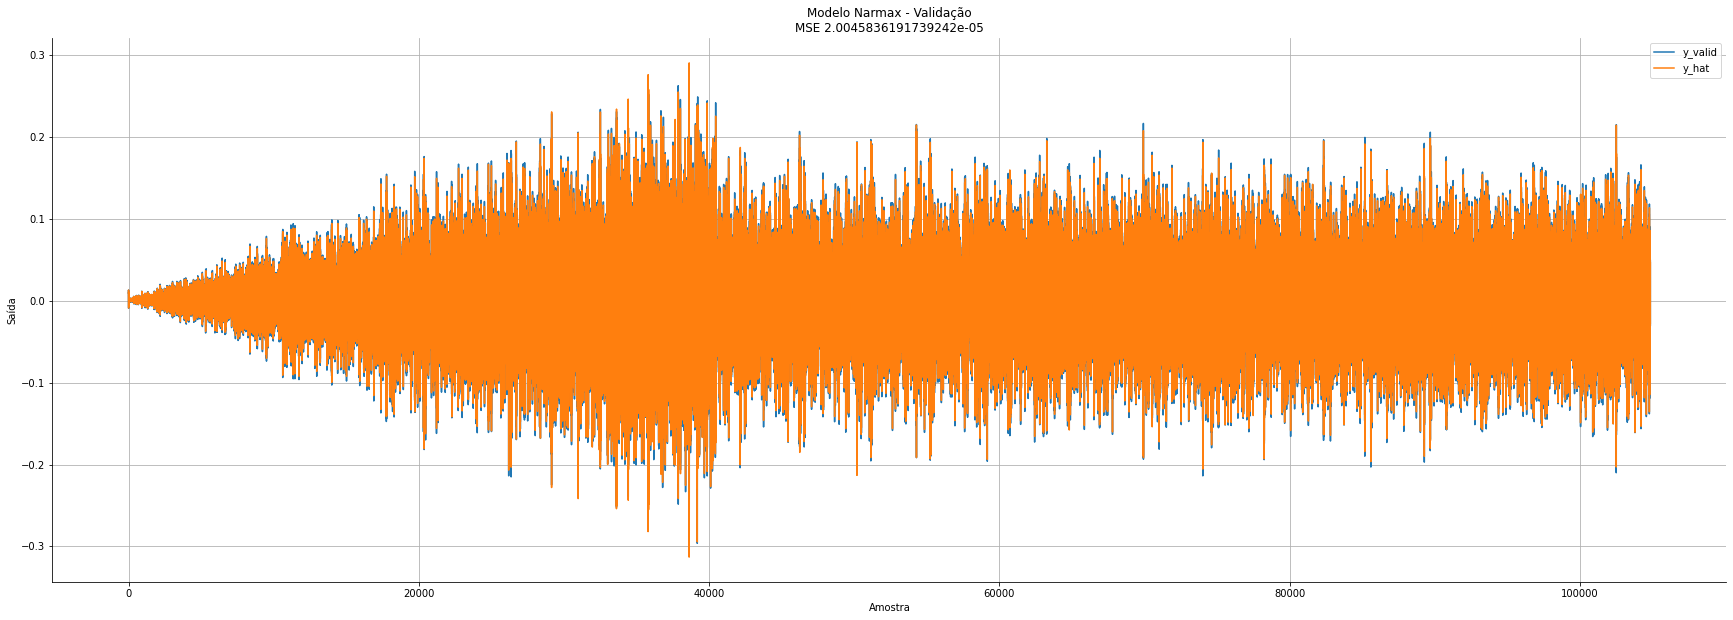

In [47]:
yhat = model.predict(X=x_valid, y=y_valid)
mse = mean_squared_error(y_valid, yhat)
plt.figure(figsize = (30,10))
t = np.arange(y_valid.size)
sns.lineplot(x=t,y=y_valid.flatten(),label='y_valid')
sns.lineplot(x=t,y=yhat.flatten(),label='y_hat')
plt.title(f'Modelo Narmax - Validação\nMSE {mse}')
plt.xlabel('Amostra')
plt.ylabel('Saída')

plt.grid()
plt.show()
plt.close()

## Modelo Linear e Não-Linear
Abaixo os códigos para os modelos que serão usados nos modelos de Wiener e Hammerstein  

In [7]:
import sys
sys.path.insert(0,'..')
from modelos.lsqr_batelada import lsqr_batelada, gerar_yest_1
from modelos.lsqr_polinomial import lsqrt_polinomial, 

## Wiener Model
Combinação de um estimador linear seguido de um não-linear.

In [8]:
best = 1000
for na, nb in product(range(1,6), range(1,6)):
    theta1, w_hat = lsqr_batelada(u=x_train, y=y_train, na=na, nb=nb, delay=0)
    nbest = mean_squared_error(y_train, w_hat)
    if nbest < best:
        best = nbest
        print(f'na: {na}, nb: {nb}')
        print(best)
    for n in range(1,11):
        theta2, y_hat = lsqrt_polinomial(u=w_hat, y=y_train, n=7)
        nbest = mean_squared_error(y_train, y_hat)
        if nbest < best:
            best = nbest
            print(f'n: {n}')
            print(best)

na: 1, nb: 1
0.0034928890311941613
na: 1, nb: 2
0.002808675488531236
na: 1, nb: 3
0.002511091660462808
n: 1
0.0025108531799696004


In [ ]:
theta1, w_hat = lsqr_batelada(u=x_train, y=y_train, na=na, nb=nb, delay=0)
theta2, y_hat = lsqrt_polinomial(u=w_hat, y=y_train, n=7)



## Hammerstein Model
Combinação de um estimador não-linear seguido de um linear.

In [9]:
best = 1000
for n in range(1,11):
    theta1, w_hat = lsqrt_polinomial(u=x_train, y=y_train, n=5)
    nbest = mean_squared_error(y_train, w_hat)
    if nbest < best:
        best = nbest
        print(f'n: {n}')
        print(best)
    for na, nb in product(range(1,6), range(1,6)):
        theta2, y_hat = lsqr_batelada(u=w_hat, y=y_train, na=5, nb=5, delay=0)
        nbest = mean_squared_error(y_train, y_hat)
        if nbest < best:
            best = nbest
            print(f'na: {na}, nb: {nb}')
            print(best)

n: 1
0.002526018165547565
